In [18]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rc("font", family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False

# Drive 마운트
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    print("Google Drive 마운트 완료.")
except ImportError:
    print("Google Colab 환경이 아닙니다. 로컬 경로를 직접 설정하세요.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [19]:
# ==========================================
# 1. 환경 설정 (Configuration)
# ==========================================
class Config:
    PROJECT_DIR = "/content/drive/MyDrive/Projects/MindLog"
    DATA_DIR = os.path.join(PROJECT_DIR, "processed")
    MODEL_DIR = os.path.join(PROJECT_DIR, "models")

    # 모델 선택
    MODEL_NAME = "skt/kobert-base-v1"

    # 하이퍼파라미터
    MAX_LEN = 128
    BATCH_SIZE = 32
    EPOCHS = 5
    LEARNING_RATE = 5e-5
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(Config.MODEL_DIR, exist_ok=True)
print(f"[INFO] Device: {Config.DEVICE}")

[INFO] Device: cuda


In [20]:
# ==========================================
# 2. 데이터셋 클래스 (CSV -> Tokenizing)
# ==========================================
class MultiTaskDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_len):
        self.data = pd.read_csv(csv_path)
        self.tokenizer = tokenizer
        self.max_len = max_len
        print(f"[INFO] 데이터 로드 완료: {csv_path} ({len(self.data)} rows)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row["merged_text"])
        label_emo = int(row["label_emotion"])
        label_sit = int(row["label_situation"])

        inputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"][0],
            "attention_mask": inputs["attention_mask"][0],
            "labels_emotion": torch.tensor(label_emo, dtype=torch.long),
            "labels_situation": torch.tensor(label_sit, dtype=torch.long)
        }

In [21]:
# ==========================================
# 3. 멀티태스크 모델 정의
# ==========================================
class SentimentMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_emo_classes, num_sit_classes):
        super(SentimentMultiTaskModel, self).__init__()

        # 1. Backbone
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        # 2. Classifier Heads
        self.dropout = nn.Dropout(0.1)
        self.emo_classifier = nn.Linear(hidden_size, num_emo_classes) # 감정용 헤드
        self.sit_classifier = nn.Linear(hidden_size, num_sit_classes) # 상황용 헤드

    def forward(self, input_ids, attention_mask, labels_emotion=None, labels_situation=None):
        # Encoder Output
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # [CLS] 토큰의 벡터 (문장 전체의 특징)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)

        # 각 헤드 통과
        emo_logits = self.emo_classifier(cls_output)
        sit_logits = self.sit_classifier(cls_output)

        loss = None
        if labels_emotion is not None and labels_situation is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_emo = loss_fct(emo_logits, labels_emotion)
            loss_sit = loss_fct(sit_logits, labels_situation)
            # [Loss 합산] 두 태스크의 Loss를 더함 (필요시 가중치 조절 가능)
            loss = loss_emo + loss_sit

        return {
            "loss": loss,
            "logits_emotion": emo_logits,
            "logits_situation": sit_logits
        }

In [22]:
# ==========================================
# 4. 학습 준비
# ==========================================
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)

# DataLoader
train_dataset = MultiTaskDataset(os.path.join(Config.DATA_DIR, "train.csv"), tokenizer, Config.MAX_LEN)
valid_dataset = MultiTaskDataset(os.path.join(Config.DATA_DIR, "valid.csv"), tokenizer, Config.MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)

# Label Map 로드 (클래스 개수 확인용)
with open(os.path.join(Config.DATA_DIR, "label_map.pkl"), "rb") as f:
    label_map = pickle.load(f)
    num_emo = len(label_map["emotion2id"])
    num_sit = len(label_map["situation2id"])
    # 시각화를 위해 라벨 이름 리스트 저장
    emo_names = [label_map["id2emotion"][i] for i in range(num_emo)]
    sit_names = [label_map["id2situation"][i] for i in range(num_sit)]

print(f"[INFO] 감정 클래스: {num_emo}개, 상황 클래스: {num_sit}개")

# Model Load
model = SentimentMultiTaskModel(Config.MODEL_NAME, num_emo, num_sit)
model.to(Config.DEVICE)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
total_steps = len(train_loader) * Config.EPOCHS
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

[INFO] 데이터 로드 완료: /content/drive/MyDrive/Projects/MindLog/processed/train.csv (51630 rows)
[INFO] 데이터 로드 완료: /content/drive/MyDrive/Projects/MindLog/processed/valid.csv (6641 rows)
[INFO] 감정 클래스: 6개, 상황 클래스: 12개


In [23]:
# ==========================================
# 5. 성능 평가 함수 (Acc + F1)
# ==========================================
def calculate_metrics(preds, labels):
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    acc = accuracy_score(labels_flat, pred_flat)
    f1 = f1_score(labels_flat, pred_flat, average="weighted") # 불균형 고려
    return acc, f1, pred_flat, labels_flat

In [24]:
# ==========================================
# 6. 학습 및 검증 루프
# ==========================================
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()

        inputs = {k: v.to(Config.DEVICE) for k, v in batch.items()}
        outputs = model(**inputs)

        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0

    # 성능 저장을 위한 리스트
    all_emo_preds, all_emo_labels = [], []
    all_sit_preds, all_sit_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = {k: v.to(Config.DEVICE) for k, v in batch.items()}
            outputs = model(**inputs)

            total_loss += outputs["loss"].item()

            # 예측값 수집 (CPU로 이동)
            emo_logits = outputs["logits_emotion"].detach().cpu().numpy()
            sit_logits = outputs["logits_situation"].detach().cpu().numpy()

            all_emo_preds.extend(np.argmax(emo_logits, axis=1))
            all_emo_labels.extend(inputs["labels_emotion"].cpu().numpy())

            all_sit_preds.extend(np.argmax(sit_logits, axis=1))
            all_sit_labels.extend(inputs["labels_situation"].cpu().numpy())

    # 최종 메트릭 계산
    emo_acc = accuracy_score(all_emo_labels, all_emo_preds)
    sit_acc = accuracy_score(all_sit_labels, all_sit_preds)

    # 리턴: Loss, Emo_Acc, Sit_Acc, 그리고 상세 분석을 위한 전체 데이터
    return total_loss / len(loader), emo_acc, sit_acc, (all_emo_labels, all_emo_preds), (all_sit_labels, all_sit_preds)

In [25]:
# ==========================================
# 7. 실행 (Main Loop)
# ==========================================
best_loss = float("inf")

# 시각화용 데이터 저장 변수
final_emo_results = None
final_sit_results = None

print("\n===== 학습 시작 =====")
for epoch in range(Config.EPOCHS):
    print(f"\nEpoch {epoch + 1}/{Config.EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    val_loss, emo_acc, sit_acc, emo_res, sit_res = eval_epoch(model, valid_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Valid Loss: {val_loss:.4f} | Emo Acc: {emo_acc:.4f} | Sit Acc: {sit_acc:.4f}")

    # Loss 기준 저장 (또는 Acc 기준으로 변경 가능)
    if val_loss < best_loss:
        best_loss = val_loss
        final_emo_results = emo_res
        final_sit_results = sit_res

        # 모델 저장
        torch.save(model.state_dict(), os.path.join(Config.MODEL_DIR, "best_multitask_model.bin"))
        print(" >> Best Model Saved!")


===== 학습 시작 =====

Epoch 1/5


Evaluating: 100%|██████████| 208/208 [00:44<00:00,  4.71it/s]


Train Loss: 4.1816
Valid Loss: 4.2337 | Emo Acc: 0.1676 | Sit Acc: 0.2052
 >> Best Model Saved!

Epoch 2/5


Evaluating: 100%|██████████| 208/208 [00:44<00:00,  4.72it/s]


Train Loss: 4.1742
Valid Loss: 4.2290 | Emo Acc: 0.1676 | Sit Acc: 0.2052
 >> Best Model Saved!

Epoch 3/5


Evaluating: 100%|██████████| 208/208 [00:44<00:00,  4.69it/s]


Train Loss: 4.1553
Valid Loss: 4.1906 | Emo Acc: 0.1897 | Sit Acc: 0.2052
 >> Best Model Saved!

Epoch 4/5


Evaluating: 100%|██████████| 208/208 [00:44<00:00,  4.70it/s]


Train Loss: 4.0302
Valid Loss: 4.0000 | Emo Acc: 0.2399 | Sit Acc: 0.2220
 >> Best Model Saved!

Epoch 5/5


Evaluating: 100%|██████████| 208/208 [00:44<00:00,  4.66it/s]


Train Loss: 3.9285
Valid Loss: 3.9644 | Emo Acc: 0.2342 | Sit Acc: 0.2379
 >> Best Model Saved!


In [26]:
# ==========================================
# 8. 심층 분석 (Confusion Matrix & Report)
# ==========================================
def plot_confusion_matrix(labels, preds, class_names, title):
    cm = pd.crosstab(pd.Series(labels, name="Actual"),
                     pd.Series(preds, name="Predicted"),
                     normalize="index") # 비율로 표시

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.show()


===== 최종 성능 분석 =====

[Emotion Report]
              precision    recall  f1-score   support

          기쁨       0.43      0.16      0.24      1213
          당황       0.20      0.23      0.22      1048
          분노       0.25      0.25      0.25      1257
          불안       0.22      0.35      0.27      1113
          상처       0.17      0.14      0.15      1007
          슬픔       0.24      0.28      0.26      1003

    accuracy                           0.23      6641
   macro avg       0.25      0.23      0.23      6641
weighted avg       0.26      0.23      0.23      6641



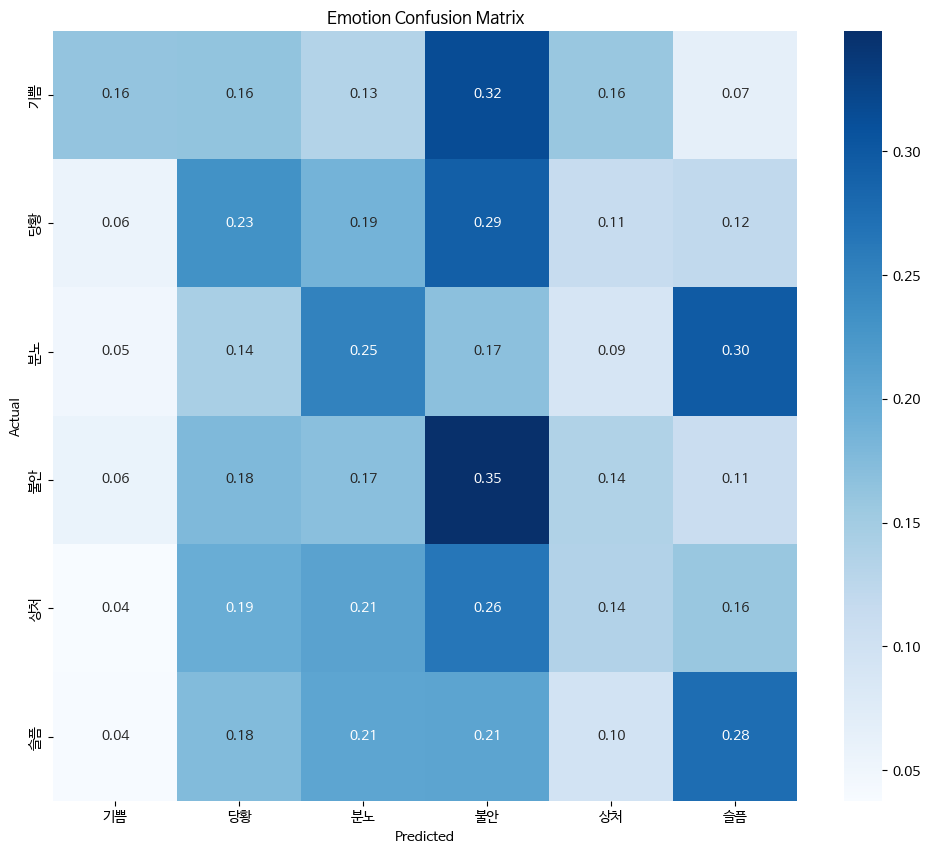


[Situation Report]
              precision    recall  f1-score   support

        가족관계       0.19      0.09      0.13       390
          건강       0.14      0.07      0.09       380
       건강,죽음       0.23      0.07      0.11       761
        대인관계       0.24      0.72      0.36      1363
대인관계(부부, 자녀)       0.12      0.00      0.00       452
    연애,결혼,출산       0.24      0.38      0.30       376
          재정       0.33      0.02      0.04       557
  재정,은퇴,노후준비       0.00      0.00      0.00       313
 직장, 업무 스트레스       0.00      0.00      0.00       433
    진로,취업,직장       0.16      0.21      0.18       569
    학교폭력/따돌림       0.44      0.36      0.40       551
     학업 및 진로       0.09      0.00      0.01       496

    accuracy                           0.24      6641
   macro avg       0.18      0.16      0.13      6641
weighted avg       0.20      0.24      0.17      6641



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


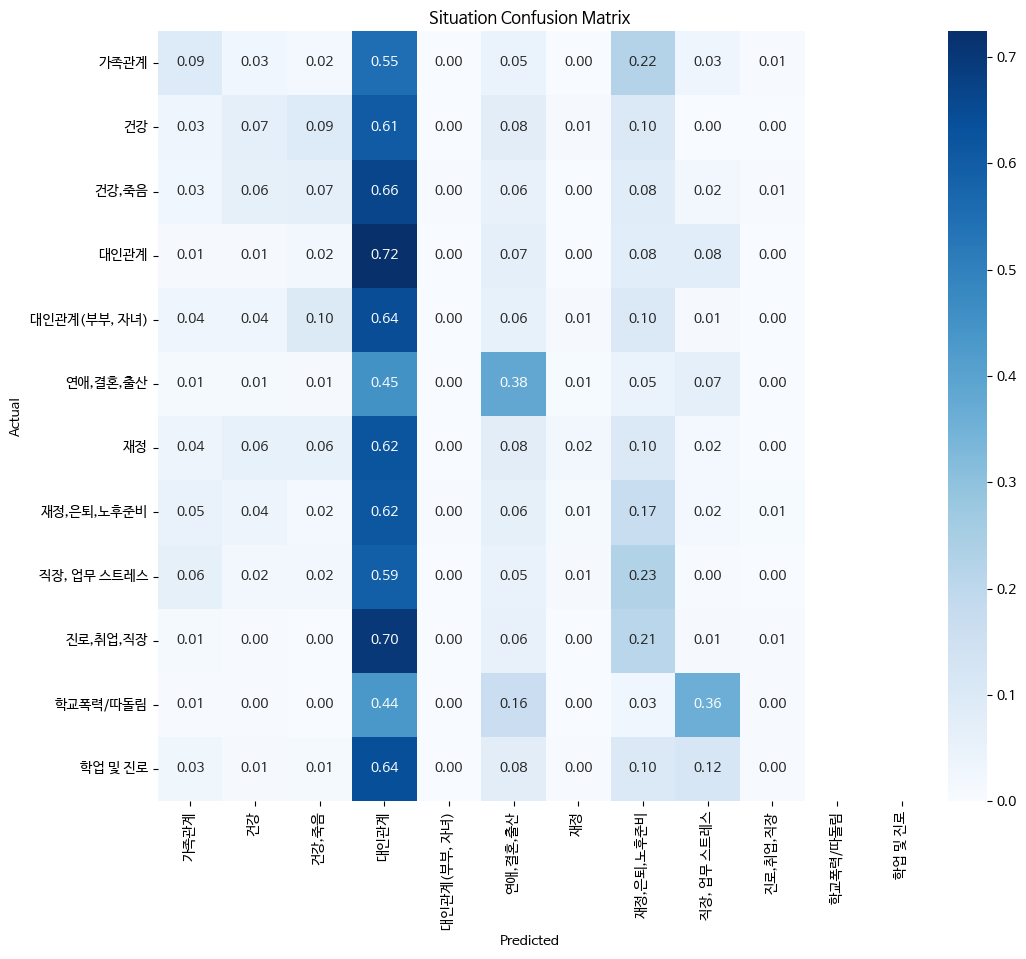

In [27]:
print("\n===== 최종 성능 분석 =====")
# (1) 감정 분석 결과
print("\n[Emotion Report]")
y_true, y_pred = final_emo_results
print(classification_report(y_true, y_pred, target_names=emo_names))
plot_confusion_matrix(y_true, y_pred, emo_names, "Emotion Confusion Matrix")

# (2) 상황 분석 결과
print("\n[Situation Report]")
y_true, y_pred = final_sit_results
print(classification_report(y_true, y_pred, target_names=sit_names))
plot_confusion_matrix(y_true, y_pred, sit_names, "Situation Confusion Matrix")